In [1]:
import stackstac
import pystac
import pystac_client
import numpy as np
import geopandas as gpd
from datetime import datetime
import os
from dask.distributed import Client
import dask.diagnostics
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# MODIFY PARAMETERS

#-------------------------------------------------------------------------
# comment ONE of these out at a time
#relative_orbit_number = 137 # change to get any particular relative orbit
#orbit_direction = 'ascending' # 'ascending', descending', 'all'
#-------------------------------------------------------------------------
# define time slice
today = datetime.today().strftime('%Y-%m-%d')
time_slice = slice('2020-01-01','2020-12-31') # All of 2020
#time_slice = slice('2017-01-01',today)
#-------------------------------------------------------------------------
# what months are represented with colors
time_slice_display = slice('2020-02-01','2020-7-31')
#-------------------------------------------------------------------------
polarization ='gamma0_vv'
#-------------------------------------------------------------------------
bounding_box_gf = gpd.read_file('shapefiles/mt_rainier.geojson')
#-------------------------------------------------------------------------
rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson')
#-------------------------------------------------------------------------
cloud_cover_threshold = 20
resample_freq = "W" # https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
shapefile_clip = True

In [3]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [4]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35247 instead
  warnings.warn(


In [5]:
lower_lon, upper_lat, upper_lon, lower_lat = bounding_box_gf.bounds.values[0]
lon = (lower_lon + upper_lon)/2
lat = (lower_lat + upper_lat)/2

In [6]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [7]:
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2010-01-01/2025-01-01"
).get_all_items()

In [8]:
stack = stackstac.stack(items)
xr.set_options(keep_attrs=True)
stack

<xarray.DataArray 'stackstac-4d9d8c1deefc42c0a3b81918b1a90c87' (time: 1151, band: 17, y: 20982, x: 10980)>
dask.array<fetch_raster_window, shape=(1151, 17, 20982, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time                        (time) datetime64[ns] 2017-01-03T19:09:49 ......
    id                          (time) <U24 'S2A_10TES_20170103_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                           (y) float64 5.3e+06 5.3e+06 ... 5.09e+06
    view:off_nadir              int64 0
    updated                     (time) <U24 '2020-09-27T21:19:28.475Z' ... '2...
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20170103T190802_N0001...
    sentinel:valid_cloud_cover  (time) bool True True True ... True True True
    instruments                 <U3 'msi'
    sentinel:grid_square        (time) <U2 'ES' 'ET' 'ET' ... 'ES' 'ET' 'ES'
    constellation               <U10 'sentinel-2'
    sentinel:sequence           (time) <U1 '0' '0' '0' '0' ... '0' '0' '0' '0'
    platform                    (time) <U11 'sentinel-2a' ... 'sentinel-2b'
    eo:cloud_cover              (time) float64 3.04 0.23 6.45 ... 89.48 95.01
    sentinel:latitude_band      <U1 'T'
    proj:epsg                   int64 32610
    gsd                         (band) object 10 10 60 10 ... 20 None None None
    sentinel:data_coverage      (time) float64 100.0 95.68 99.15 ... 98.79 80.23
    created                     (time) <U24 '2020-09-27T21:19:28.475Z' ... '2...
    sentinel:utm_zone           int64 10
    data_coverage               (time) object None None None ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None None 'coastal' ... None None
    center_wavelength           (band) object None None 0.4439 ... None None
    full_width_half_max         (band) object None None 0.027 ... None None None
    epsg                        int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

In [9]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [10]:
lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]

#stack.sel(time=time_slice) 298 images for the year
#lowcloud.sel(time=time_slice) 87 lowcloud days for the year

In [11]:
# select bands
rgb = lowcloud.sel(band=["B04","B03","B02"])

nir, red, vir, swir = lowcloud.sel(band="B08"), lowcloud.sel(band="B04"), lowcloud.sel(band="B03"), lowcloud.sel(band="B11")
# NDVI is (B8-B4)/(B8+B4) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndvi = (nir-red)/(nir+red)
# NDSI is (B3-B11)/(B3+B11) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndsi = (vir-swir)/(vir+swir)


# SCL classifications https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/
scl = lowcloud.sel(band="SCL")
# look at preciptable water vapor? maybe something telling about melt / evaporation
wvp = lowcloud.sel(band="WVP")

In [12]:
scenes_rgb = rgb.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndvi = ndvi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndsi = ndsi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [13]:
%%time
frames_rgb_all = scenes_rgb.compute()
frames_rgb = frames_rgb_all.dropna('time',how='all')

CPU times: user 2min 43s, sys: 10.4 s, total: 2min 54s
Wall time: 1min 49s


In [ ]:
%%time
frames_ndvi_all = scenes_ndvi.compute()
frames_ndvi = frames_ndvi_all.dropna('time',how='all')

In [ ]:
%%time 
frames_ndsi_all = scenes_ndsi.compute()
frames_ndsi = frames_ndsi_all.dropna('time',how='all')

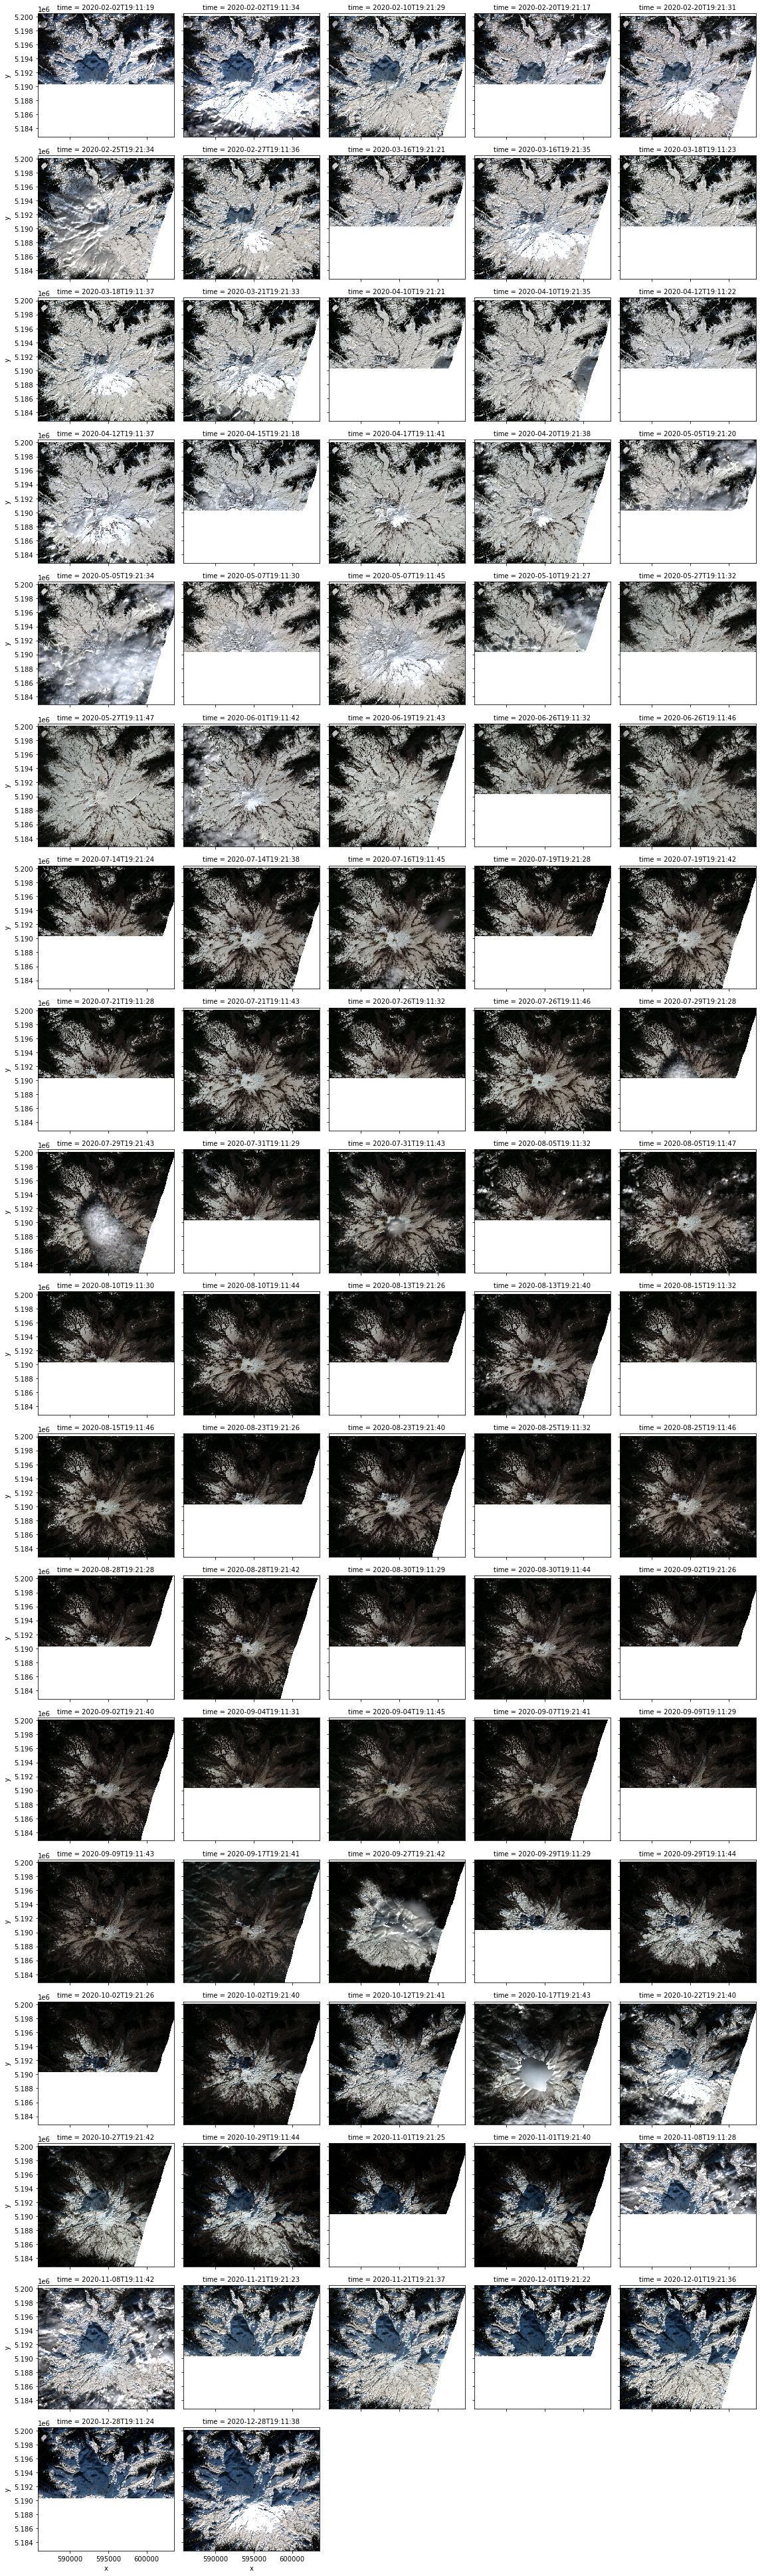

In [14]:
frames_rgb.plot.imshow(col="time", col_wrap = 5, rgb='band', robust=True);

In [ ]:
frames_ndvi.plot.imshow(col="time", col_wrap = 5, robust=True);

In [ ]:
frames_ndsi.plot.imshow(col="time", col_wrap = 5, robust=True);

In [ ]:

#if 'resample_freq' in locals():
    #monthly = rgb.resample(time="MS").median("time", keep_attrs=True)
#    resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
#else:
#    resampled = lowcloud

In [ ]:
if shapefile_clip == True:
    rainier_glaciers = rainier_glaciers.to_crs(stack.crs)
    frames_nis = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Nisqually Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False)
    frames_emm = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Emmons Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_car = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Carbon Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_tah = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Tahoma Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_named = frames_ndsi.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)

In [ ]:
# look for local min for melt timings
f,ax = plt.subplots(figsize=(20,8))

ax.plot(frames_ndsi.time,frames_ndsi.mean(dim=['x','y']),label='Entire Scene')
ax.plot(frames_nis.time,frames_nis.mean(dim=['x','y']),label='Nisqually Glacier')
ax.plot(frames_emm.time,frames_emm.mean(dim=['x','y']),label='Emmons Glacier')
ax.plot(frames_car.time,frames_car.mean(dim=['x','y']),label='Carbon Glacier')
ax.plot(frames_tah.time,frames_tah.mean(dim=['x','y']),label='Tahoma Glacier')
ax.plot(frames_named.time,frames_named.mean(dim=['x','y']),label='All Glaciers')

#ax2=ax.twinx()
#snotel_df.plot.scatter(x='date_time_utc',y='value',ax=ax2,c='r',alpha=0.4,label='SWE')

ax.set_xlim([time_slice.start,time_slice.stop])
ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
ax.set_ylabel('NDSI')

ax.set_title(f'Sentinel2 NDSI Values \nfor ({time_slice.start}, {time_slice.stop})')

In [ ]:
# train all S2 bands on SAR backscatter data? 
# rate at which NDSI dips proportional to debris?

In [ ]:
frames_rgb = None
frames_ndvi = None
frames_ndsi = None

frames_nis = None
frames_emm = None
frames_car = None
frames_tah = None
frames_named = None

In [ ]:
frames_rgb = None

In [ ]:
%%time
scenes_all_bands = lowcloud.sel(band=['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12']).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
frames_all_bands = scenes_all_bands.compute()

In [ ]:
f,ax = plt.subplots(figsize=(20,8))
frames_all_bands = frames_all_bands.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)
ax.plot(frames_all_bands.time,frames_all_bands.mean(dim=['x','y']),label='Entire Scene')

ax.set_xlim([time_slice.start,time_slice.stop])
ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
ax.set_ylabel('Reflectance')

ax.set_title(f'Sentinel2 All Band \nfor ({time_slice.start}, {time_slice.stop})')